# Transverse Mode Coupling Instability in LHC

This notebook demonstrates the transverse mode coupling instability (TMCI, sometimes also called fast head-tail instability) due to wake field interaction with a 2-particle model. The instability mechanism feeds energy from one synchrotron sideband (head-tail mode) of the betatron tune to another, when their frequencies overlap. Here it will be mode 0 and mode -1 for an impedance regime similar to the real LHC (where the instability threshold is an order of magnitude above this example). The two modes couple at a certain intensity because their frequencies are shifted by the wake field in different slopes.

In the following we create a macro-particle beam made of 2 particles in the LHC at vanishing chromaticity. They interact via a broad-band resonator wakefield. The motion of the 2 macro-particles illustrates the instability mechanism in the following PyHEADTAIL simulation.

Created 2018 by David Amorim and Adrian Oeftiger

## Videos (results from simulations):

### Below the TMCI threshold at $N=10^{10}$ ppb:

Mode 0 (in phase transversely):

In [1]:
%%HTML
<video controls>
  <source src="./plots_mode0_weak_impedance/video.webm" type="video/webm">
</video>

Mode 1 (in anti phase transversely):

In [2]:
%%HTML
<video controls>
  <source src="./plots_mode1_weak_impedance/video.webm" type="video/webm">
</video>

### Above the TMCI threshold at $N=10^{11}$ ppb:

Mode 0 (in phase transversely):

In [3]:
%%HTML
<video controls>
  <source src="./plots_mode0_strong_impedance/video.webm" type="video/webm">
</video>

Mode 1 (in anti phase transversely):

In [103]:
%%HTML
<video controls>
  <source src="./plots_mode1_strong_impedance/video.webm" type="video/webm">
</video>

.

.

.

$\implies$ Shall we simulate this? :-)


## Imports for PyHEADTAIL simulations:

In [4]:
from __future__ import division, print_function
range_ = range
range = xrange


import time

import numpy as np
# np.random.seed(10000042)
import h5py
from scipy.constants import e, m_p, c

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(font_scale=1.4)

# Change the size of the fonts
params = {'font.size': 50,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'legend.fontsize': 16,
          'legend.handlelength': 2,
         }
plt.rcParams.update(params)

In [5]:
import os, sys
sys.path.append('../')
try:
    from settings import *
except ImportError:
    pass

In [6]:
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.impedances.wakes import WakeTable, WakeField, CircularResonator
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.monitors.monitors import (
    BunchMonitor, ParticleMonitor, SliceMonitor)
from PyHEADTAIL.particles.particles import Particles
from PyHEADTAIL.general.printers import SilentPrinter

PyHEADTAIL v1.12.4.7




## Preparing the simulation:

Here we define the beam and machine parameters, including the broadband resonator's shunt impedance, frequency and quality factor.

An intensity of $N=10^{11}$ ppb is unstable, while $N=10^{10}$ ppb remains below the TMCI treshold here.

In [7]:
# BEAM AND MACHINE PARAMETERS
# ============================

intensity_stable = 1e10
intensity_unstable = 1e11

# Beam parameters
intensity = intensity_stable
epsn_x = 3.e-6 # normalised horizontal emittance in meters rad
epsn_y = 3.e-6 # normalised vertical emittance in meters rad
sigma_z = 1.2e-9 * c / 4. # RMS bunch length in meters

# Resonator parameters
R_shunt = 90.0e6
frequency = 0.5e9
Q = 1

# Machine parameters
chroma = 0
longitudinal_mode = 'linear'

from LHC import LHC

machine = LHC(n_segments=1,
              machine_configuration='LHC_6.5TeV_collision_2016',
              longitudinal_mode=longitudinal_mode,
              Qp_x=[chroma], Qp_y=[chroma], 
              printer=SilentPrinter())

The bunch is generated with only two macro-particles in opposite synchrotron phases.
To distinguish a mode 0 from a mode 1, the initial 
transverse positions of the two particles have to be adapted accordingly: 

mode 0: same offset, e.g. both at +1μm

mode 1: opposite offset, e.g. +1μm and -1μm

In [8]:
mode0 = [1.0e-6, 1.0e-6]
mode1 = [-1.0e-6, 1.0e-6]

mode_initialise = mode1

initial_conditions = {
  'x': np.array(mode_initialise, dtype=np.float64),
  'xp': np.array([0, 0], dtype=np.float64),
  'y': np.array([0, 0], dtype=np.float64),
  'yp': np.array([0, 0], dtype=np.float64),
  'z': np.array([-sigma_z, +sigma_z], dtype=np.float64),
  'dp': np.array([0, 0], dtype=np.float64),
}

bunch = Particles(
    2, intensity/2, e, m_p, machine.circumference, machine.gamma, 
    coords_n_momenta_dict=initial_conditions)

Resolving the wake field accurately for the location of the trailing particle requires a fine slicing interval, we will therefore use 1000 slices. Longitudinal motion is bound on the interval $[-\sigma_z, +\sigma_z]$, we add $10\%$ margin for the slicing interval:

In [9]:
# CREATE BEAM SLICERS
# ===================
slicer_for_wakefields = UniformBinSlicer(
    1000, z_cuts=(-1.1*sigma_z, 1.1*sigma_z))

# CREATE WAKES
# ============
wake_table = CircularResonator(R_shunt, frequency, Q)
wake_field = WakeField(slicer_for_wakefields, wake_table)

machine.one_turn_map.append(wake_field)

The machine one-turn map now contains 3 elements: we will track the macro-particles' betatron motion around the ring, advance their synchrotron phase and finally apply the broadband resonator kick:

In [10]:
machine.one_turn_map

Fixing the length of the simulation run time:

In [11]:
n_turns = 2000

The coordinates of the particles will be recorded at each turn in these empty arrays:

In [12]:
xsave = np.zeros((n_turns, bunch.macroparticlenumber), dtype=np.float32)
xpsave = np.zeros((n_turns, bunch.macroparticlenumber), dtype=np.float32)
ysave = np.zeros((n_turns, bunch.macroparticlenumber), dtype=np.float32)
ypsave = np.zeros((n_turns, bunch.macroparticlenumber), dtype=np.float32)
zsave = np.zeros((n_turns, bunch.macroparticlenumber), dtype=np.float32)
dpsave = np.zeros((n_turns, bunch.macroparticlenumber), dtype=np.float32)

mxsave = np.zeros(n_turns, dtype=np.float32)
mysave = np.zeros(n_turns, dtype=np.float32)
mzsave = np.zeros(n_turns, dtype=np.float32)

## Tracking:

In [13]:
# TRACKING LOOP
# =============
print ('\n--> Begin tracking...\n')

# GO!!!
for i in range(n_turns):

    t0 = time.clock()

    # track the beam around the machine for one turn:
    machine.track(bunch)

    mx, my, mz = bunch.mean_x(), bunch.mean_y(), bunch.mean_z()

    xsave[i][:] = bunch.x
    xpsave[i][:] = bunch.xp
    ysave[i][:] = bunch.y
    ypsave[i][:] = bunch.yp
    zsave[i][:] = bunch.z
    dpsave[i][:] = bunch.dp
    
    mxsave[i] = mx
    mysave[i] = my
    mzsave[i] = mz
    
    # print status all 100 turns:
    if i % 100 == 0:
        t1 = time.clock()
        print ('Centroids: ({:.3g}, {:.3g}, {:.3g})'
               ' @ turn {:d}, {:g} ms, {:s}'.format(
                    mx, my, mz, i, (t1-t0)*1e3, time.strftime(
                        "%d/%m/%Y %H:%M:%S", time.localtime()))
        )

print ('\n*** Successfully completed!')


--> Begin tracking...

Centroids: (0, 0, 0) @ turn 0, 4.618 ms, 04/06/2018 19:51:58
Centroids: (3.77e-08, 0, 0) @ turn 100, 1.276 ms, 04/06/2018 19:51:58
Centroids: (3.66e-08, 0, 0) @ turn 200, 1.276 ms, 04/06/2018 19:51:59
Centroids: (7.66e-10, 0, 0) @ turn 300, 1.292 ms, 04/06/2018 19:51:59
Centroids: (-3.54e-08, 0, 0) @ turn 400, 1.285 ms, 04/06/2018 19:51:59
Centroids: (-3.33e-08, 0, 0) @ turn 500, 1.288 ms, 04/06/2018 19:51:59
Centroids: (2.59e-12, 0, 0) @ turn 600, 1.286 ms, 04/06/2018 19:51:59
Centroids: (3.38e-08, 0, 0) @ turn 700, 1.283 ms, 04/06/2018 19:51:59
Centroids: (3.05e-08, 0, 0) @ turn 800, 1.334 ms, 04/06/2018 19:51:59
Centroids: (-2.96e-10, 0, 0) @ turn 900, 1.326 ms, 04/06/2018 19:51:59
Centroids: (-3.17e-08, 0, 0) @ turn 1000, 1.326 ms, 04/06/2018 19:52:00
Centroids: (-2.79e-08, 0, 0) @ turn 1100, 1.334 ms, 04/06/2018 19:52:00
Centroids: (-3.27e-10, 0, 0) @ turn 1200, 1.325 ms, 04/06/2018 19:52:00
Centroids: (2.79e-08, 0, 0) @ turn 1300, 1.323 ms, 04/06/2018 19:5

## Plotting the results:

In [14]:
# Find the maximum values of the data and use
# them as a limit for the plots
lim_x = np.abs(max(xsave.max(), xsave.min(), key=abs))
lim_xp = np.abs(max(xpsave.max(), xpsave.min(), key=abs))

lim_z = np.abs(max(zsave.max(), zsave.min(), key=abs))
lim_dp = np.abs(max(dpsave.max(), dpsave.min(), key=abs))

lim_x = 1.0e-6
lim_z = 0.1

We store the plots in a subdirectory to be able to create a video afterwards. Be aware, the plotting may take some minutes.

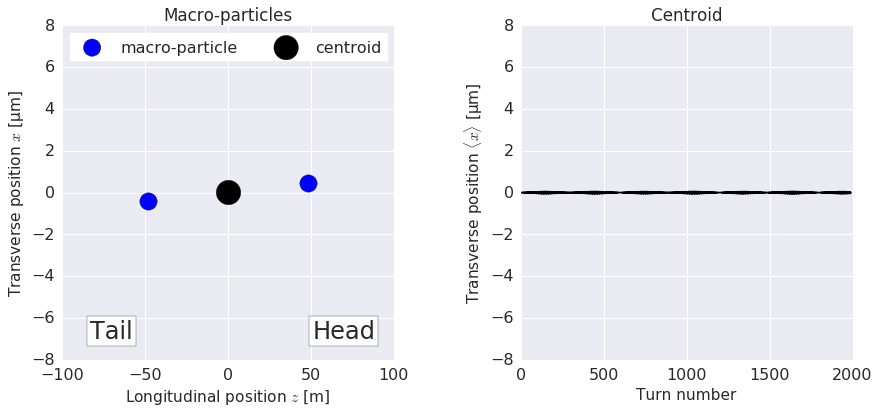

In [15]:
save_directory = 'plots_mode1_weak_impedance/'

if not os.path.exists('./'+save_directory):
    os.makedirs('./'+save_directory)

for turn_number in np.arange(0, n_turns , 10):

    plt.close('all')
    fig, ax_list = plt.subplots(1, 2, figsize=(13.5, 7), dpi=100)

    ax = ax_list[0]
    
    mparticle_number = 0
    ax.scatter(zsave[turn_number, mparticle_number]*1e3, xsave[turn_number, mparticle_number]*1e6, s=300)

    mparticle_number = 1
    ax.scatter(zsave[turn_number, mparticle_number]*1e3, xsave[turn_number, mparticle_number]*1e6, s=300, 
               label='macro-particle')

    ax.scatter(mzsave[turn_number]*1e3, mxsave[turn_number]*1e6, s=600, c='k', label='centroid')
    
    ax.set_xlim(-1.0 * lim_z*1e3, 1.0 * lim_z*1e3)
    ax.set_ylim(-8.0 * lim_x*1e6, 8.0 * lim_x*1e6)

    ax.set_xlabel('Longitudinal position $z$ [m]')
    ax.set_ylabel(u'Transverse position $x$ [μm]')
    
#     ax.text(0.05, 0.9, 'Turn: {:04d}'.format(turn_number),
#             verticalalignment='bottom', horizontalalignment='left',
#             transform=ax.transAxes, fontsize=18,
#             bbox={'facecolor':'white', 'alpha':0.9, 'pad':3})
    
    ax.text(0.15, 0.05, 'Tail',
        verticalalignment='bottom', horizontalalignment='center',
        transform=ax.transAxes, fontsize=24,
        bbox={'facecolor':'white', 'alpha':0.9, 'pad':3})
    
    ax.text(0.85, 0.05, 'Head',
        verticalalignment='bottom', horizontalalignment='center',
        transform=ax.transAxes, fontsize=24,
        bbox={'facecolor':'white', 'alpha':0.9, 'pad':3})
    
    lgd = ax.legend(loc=2, frameon=True, ncol=2)
    lgd.get_frame().set_facecolor('white')
    
    ax.set_title('Macro-particles')
    
    ax = ax_list[1]
    
    ax.plot(np.arange(0, turn_number), mxsave[:turn_number]*1e6, c='k')
    
    ax.set_xlim(0, n_turns)
    ax.set_ylim(-8.0 * lim_x*1e6, 8.0 * lim_x*1e6)

    ax.set_xlabel('Turn number')
    ax.set_ylabel(r'Transverse position $\langle x \rangle$ ' + u'[μm]')
    
    ax.set_title('Centroid')
    
    plt.tight_layout()
    
    plt.savefig('./'+save_directory+'position{0:05d}.png'.format(turn_number))

To create a video out of the multiple files, one can use ffmpeg (on Linux).

In a terminal, create a H.264/AVC video via
```bash
$ ffmpeg -i position0%03d0.png -q:v 0 -c:v libx264 -framerate 10 -pix_fmt yuv420p video.avi
```

Or, for a web browser as for the above embedded videos:

```bash
$ ffmpeg -i position0%03d0.png -c:v libvpx -crf 10 -b:v 1M -c:a libvorbis -framerate 10 -pix_fmt yuv420p video.webm```

Like this:

In [16]:
!cd ./plots_mode0_strong_impedance/ && \
    ffmpeg -i position0%03d0.png -q:v 0 -c:v libx264 -framerate 10 -pix_fmt yuv420p video.avi

ffmpeg version 2.8.14-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.9) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e